# Praktikum Visi Komputer
## Modul ke-6

## Seam Carving dan Segmentation

Pada modul ini, kita akan mempelajari tentang perubahan ukuran citra yang *content-aware* (sadar konten). Proses ini dikenal dengan seam carving. Kita akan membahas cara mendeteksi bagian "menarik" pada sebuah gambar/citra dan cara menggunakan informasi tersebut untuk merubah ukuran citra yang diberikan tanpa merusak bagian yang menarik tadi. 

Selain itu pada modul ini juga kita akan mempelajari bagaimana melakukan segmentasi (*segmentation*) pada citra, selain itu cara memisahkan foreground dari background.


### Mengapa kita perlu Seam Carving?

Ukuran layar/screen berbeda-beda sehingga menghasilkan ukuran citra yang berbeda pula. Namun seringnya kita perlu untuk mengubah konten bergantung pada keperluan. Biasanya kita merubah citra agar muat dalam layar dengan 'memaksa' konten untuk memenuhi layar baik dengan meregangkan (*stretching*) ataupun dengan mengecilkan (*shrinking*) citra. Sayangnya, proses ini menjadikan hasil tidak sesuai dengan yang diharapkan. Seperti misalnya kita hanya merubah lebarnya saja, tingginya saja, atau keduanya sekaligus tapi tidak mengikuti aspect ratio.

In [10]:
# Berikut ini adalah gambar bebek yang asli, 
# perhatikan ukurannya adalah tinggi=522, lebar=819
import cv2

# load the image and show it
# https://i.im.ge/2021/10/20/o2yvCX.jpg
image = cv2.imread("gambar/duck1.jpg")
cv2.imshow("original", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

print (image.shape)

(304, 405, 3)


In [11]:
# Berikut ini kita coba melakukan resize lebarnya saja
import cv2

image = cv2.imread("gambar/duck1.jpg")
cv2.imshow("original", image)

img_scaled = cv2.resize(image,(300, 304), interpolation = cv2.INTER_AREA)
cv2.imshow('Scaling - Skewed Size', img_scaled) 
cv2.waitKey()
cv2.destroyAllWindows()

Perhatikan kedua gambar yang dihasilkan pada kode program di atas. Kita lihat ukuran bebeknya menjadi lebih pendek (*skewed*) pada gambar yang hanya di-resize lebarnya saja. Ukuran bebek menjadi tidak simetris. Padahal jika dilihat gambar tersebut, gambar bebek bagian yang "menarik" sehingga kita menginginkan ukuran bebeknya tetaplah simetris. Solusinya dapat menggunakan *seam carving*.

Apa makna dari *seam carving*? Sebetulnya ada sebutan lain yaitu *content-aware image resizing*, *image retargetting*, *liquid scaling*. Alasannya disebut sebagai *seam carving* disebabkan oleh cara atau proses dalam melakukan *resize* citra tersebut. Algoritma ini diusulkan oleh Shai Avidan and Ariel Shamir pada artikel papernya yang dapat didownload di http://dl.acm.org/citation.cfm?id=1276390 atau di https://faculty.idc.ac.il/arik/SCWeb/imret/index.html.

Dalam proses *resize* suatu citra, kita menginginkan konten penting pada citra tersebut tetap utuh. Kita melakukannya dengan menemukan jalur-jalur dari bagian yang kurang penting pada citra tersebut. Jalur-jalur ini disebut sebagai *seam*. Sesudah *seam* ditemukan, kita memindahkannya dari citra untuk mendapatkan suatu citra yang diskalakan ulang (*rescaled*). Proses pemindahan ini disebut *carving*. Inilah alasan kenapa algoritma *resize* ini dinamakan *seam carving*.

[![o2i2KX.png](https://i.im.ge/2021/10/19/o2i2KX.png)](https://im.ge/i/o2i2KX)

Perhatikan gambar di atas. Gambar bebek kita anggap menarik (*interesting*) sehingga bagian tersebut kita harapkan tetap utuh. Namun bagian kawasan di sekitar bebek kita anggap tidak menarik (*uninteresting*) sehingga bagian tersebut dapat dibuang. Jika kita hanya melakukan *resize* pada lebarnya saja, sedangkan tingginya tetap, maka kita perlu menemukan *seam* yang vertikal. *Seam* ini bermula dari atas dan berakhir di bawah (atau sebaliknya). Namun jika kita hanya melakukan *resize* pada tingginya saja, sedangkan lebarnya tetap, maka kita perlu menemukan *seam* yang horizontal. *Seam* ini bermula dari kiri dan berakhir di kanan (atau sebaliknya).


### Bagaimana kita mendefinisikan "menarik"?

Sebelum menghitung *seam*, kita perlu menemukan metrik yang dapat digunakan untuk menghitung *seam*. Kita perlu cara untuk memberi nilai "penting" ke setiap piksel sehingga kita dapat menemukan jalur yang kurang penting. Dalam istilah visi komputer, kita perlu memberi nilai energi untuk setiap piksel sehingga kita dapat menemukan jalur dari energi minimum. Jadi menemukan cara yang bagus untuk memberi nilai energi menjadi sangat penting karena hal ini akan memberi efek pada kualitas dari output.

Salah satu metrik yang dapat digunakan adalah nilai turunan (*derivative*) pada setiap titik. Ini merupakan indikator yang menentukan level aktivitas dalam lingkungan (*neighborhood*) tertentu. Jika ada aktivitas tertentu, maka nilai piksel akan berubah sangat jauh bedanya. Maka nilai turunan pada titik tersebut menjadi tinggi. Sebaliknya, jika suatu bagian polos dan tidak menarik, maka nilai piksel tidak akan terlalu jauh bedanya. Maka nilai turunan pada titik tersebut akan rendah.

Untuk setiap lokasi piksel, kita hitung energi dengan menjumlahkan turunan dari X dan Y pada titik tersebut. Kita menghitung turunan dengan menghitung perbedaan antara piksel sekarang dan piksel tetangganya. Proses ini telah dipelajari pada prak3 di mana kita mendeteksi tepi dan mengaplikasikan filter pada citra. Proses tersebut akan memanfaatkan matriks operasi Convolution. Nilai yang telah dihitung disimpan dalam matriks energi.

[![o299l9.md.gif](https://i.im.ge/2021/10/19/o299l9.md.gif)](https://im.ge/i/o299l9)

Sesudah kita punya matriks energi. maka kita dapat mulai menghitung *seam*. Kita perlu menemukan jalur pada citra yang memiliki energi paling rendah. Namun mencari semua jalur yang mungkin adalah *expensive* sebab perlu dimulai dari baris pertama hingga baris terakhir. Solusinya dengan memanfaatkan *dynamic programming*. 

Untuk setiap piksel pada baris sekarang, kita hitung energi dari 3 lokasi piksel yang mungkin untuk pindah pada baris berikutnya (yaitu bawah kiri, bawah, bawah kanan).Proses ini akan terus berulang hingga mencapai baris paling bawah. Pada baris paling bawah, akan dilihat mana nilai kumulatif yang paling kecil lalu kita melakukan proses backtrack ke atas. Proses ini akan menghasilkan jalur dari energi yang paling kecil. Setiap satu *seam* dihapus maka lebar citra akan berkurang sebanyak 1. Jadi kita perlu menghapus *seam* hingga mencapai ukuran yang diinginkan.


In [12]:
# Mengubah ukuran lebar citra dengan metode seam carving
import sys
import cv2
import numpy as np
from past.builtins import xrange #xrange is imported from pastbuilt

# Draw vertical seam on top of the image
def overlay_vertical_seam(img, seam):
    img_seam_overlay = np.copy(img) 
    
    # Extract the list of points from the seam
    x_coords, y_coords = np.transpose([(i,int(j)) for i,j in enumerate(seam)])
    
    # Draw a blue line on the image using the list of points
    img_seam_overlay[x_coords, y_coords] = (255,0,0)
    return img_seam_overlay

# Compute the energy matrix from the input image
def compute_energy_matrix(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Compute X derivative of the image
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
    
    # Compute Y derivative of the image
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
    
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    # Return weighted summation of the two images i.e. 0.5*X + 0.5*Y
    return cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)

# Find vertical seam in the input image
def find_vertical_seam(img, energy):
    rows, cols = img.shape[:2]
    
    # Initialize the seam vector with 0 for each element
    seam = np.zeros(img.shape[0])
    
    # Initialize distance and edge matrices
    dist_to = np.zeros(img.shape[:2]) + sys.maxsize
    dist_to[0,:] = np.zeros(img.shape[1])
    edge_to = np.zeros(img.shape[:2])
    
    # Dynamic programming; iterate using double loop and compute the paths efficiently
    for row in xrange(rows-1):
        for col in xrange(cols):
            if col != 0:
                if dist_to[row+1, col-1] > dist_to[row, col] + energy[row+1, col-1]:
                    dist_to[row+1, col-1] = dist_to[row, col] + energy[row+1, col-1]
                    edge_to[row+1, col-1] = 1

            if dist_to[row+1, col] > dist_to[row, col] + energy[row+1, col]:
                dist_to[row+1, col] = dist_to[row, col] + energy[row+1, col]
                edge_to[row+1, col] = 0

            if col != cols-1:
                if dist_to[row+1, col+1] > dist_to[row, col] + energy[row+1, col+1]:
                    dist_to[row+1, col+1] = dist_to[row, col] + energy[row+1, col+1]
                    edge_to[row+1, col+1] = -1
            
    # Retracing the path
    seam[rows-1] = np.argmin(dist_to[rows-1, :])
    for i in (x for x in reversed(xrange(rows)) if x > 0):
        seam[i-1] = seam[i] + edge_to[i, int(seam[i])]
        
    return seam

# Remove the input vertical seam from the image
def remove_vertical_seam(img, seam):
    rows, cols = img.shape[:2]
    
    # To delete a point, move every point after it one step towards the left
    for row in xrange(rows):
        for col in xrange(int(seam[row]), cols-1):
            img[row, col] = img[row, col+1]
            
    # Discard the last column to create the final output image
    img = img[:, 0:cols-1]
    return img

if __name__=='__main__':
    # Make sure the size of the input image is reasonable.
    # Large images take a lot of time to be processed.
    # Recommended size is 640x480.
    img_input = cv2.imread('gambar/duck1.jpg')
    
    # boleh juga mencoba gambar lain lagi seperti https://i.im.ge/2021/10/20/o2A2Vr.png
    # gambar ini lebih kecil sehingga proses lebih cepat
    # atau bisa dicoba gambar ini https://i.im.ge/2022/09/25/1j8ID0.bicycling.png
    
    # Use a small number to get started. Once you get an
    # idea of the processing time, you can use a bigger number.
    # To get started, you can set it to 20.
    num_seams = int(20)
    
    img = np.copy(img_input)
    img_overlay_seam = np.copy(img_input)
    energy = compute_energy_matrix(img)
    
    for i in xrange(num_seams):
        seam = find_vertical_seam(img, energy)
        img_overlay_seam = overlay_vertical_seam(img_overlay_seam, seam)
        img = remove_vertical_seam(img, seam)
        energy = compute_energy_matrix(img)
        print ('Number of seams removed =', i+1)
        
    cv2.imshow('Input', img_input)
    cv2.imshow('Seams', img_overlay_seam)
    cv2.imshow('Output', img)
    cv2.waitKey()
    cv2.destroyAllWindows()

Number of seams removed = 1
Number of seams removed = 2
Number of seams removed = 3
Number of seams removed = 4
Number of seams removed = 5
Number of seams removed = 6
Number of seams removed = 7
Number of seams removed = 8
Number of seams removed = 9
Number of seams removed = 10
Number of seams removed = 11
Number of seams removed = 12
Number of seams removed = 13
Number of seams removed = 14
Number of seams removed = 15
Number of seams removed = 16
Number of seams removed = 17
Number of seams removed = 18
Number of seams removed = 19
Number of seams removed = 20


### Memperbesar citra

Kita telah mencoba contoh di atas dan kita tahu bahwa kita dapat mengurangi lebar dari gambar tanpa merusak bagian menarik pada citra. Apakah mungkin kita dapat memperbesar citra tanpa merusak bagian menarik pada citra? 

Jawabannya adalah bisa. Kita dapat menggunakan logika yang sama. Namun saat kita menghitung seam, kita menambahkan kolom ekstra, bukan menghapusnya.

Jika kita memperbesar citra dengan menggunakan resize, maka bagian menarik menjadi tidak simetris.

[![duck](https://i.im.ge/2022/09/24/15J9NW.duck.png)](https://im.ge/i/15J9NW)

Namun jika gunakan cara yang lebih *smart* dengan menggunakan *seam carving* maka hasilnya menjadi:

[![duck1](https://i.im.ge/2022/09/24/15JtMG.duck1.md.png)](https://im.ge/i/15JtMG)

In [13]:
# Kode yang sama dengan sebelumnya, hanya di sini ditambahkan
# fungsi add_vertical_seam

import sys
import cv2
import numpy as np
from past.builtins import xrange #xrange is imported from pastbuilt

# Draw vertical seam on top of the image
def overlay_vertical_seam(img, seam):
    img_seam_overlay = np.copy(img) 
    
    # Extract the list of points from the seam
    x_coords, y_coords = np.transpose([(i,int(j)) for i,j in enumerate(seam)])
    
    # Draw a blue line on the image using the list of points
    img_seam_overlay[x_coords, y_coords] = (255,0,0)
    return img_seam_overlay

# Compute the energy matrix from the input image
def compute_energy_matrix(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Compute X derivative of the image
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
    
    # Compute Y derivative of the image
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
    
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    # Return weighted summation of the two images i.e. 0.5*X + 0.5*Y
    return cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)

# Find vertical seam in the input image
def find_vertical_seam(img, energy):
    rows, cols = img.shape[:2]
    
    # Initialize the seam vector with 0 for each element
    seam = np.zeros(img.shape[0])
    
    # Initialize distance and edge matrices
    dist_to = np.zeros(img.shape[:2]) + sys.maxsize
    dist_to[0,:] = np.zeros(img.shape[1])
    edge_to = np.zeros(img.shape[:2])
    
    # Dynamic programming; iterate using double loop and compute the paths efficiently
    for row in xrange(rows-1):
        for col in xrange(cols):
            if col != 0:
                if dist_to[row+1, col-1] > dist_to[row, col] + energy[row+1, col-1]:
                    dist_to[row+1, col-1] = dist_to[row, col] + energy[row+1, col-1]
                    edge_to[row+1, col-1] = 1

            if dist_to[row+1, col] > dist_to[row, col] + energy[row+1, col]:
                dist_to[row+1, col] = dist_to[row, col] + energy[row+1, col]
                edge_to[row+1, col] = 0

            if col != cols-1:
                if dist_to[row+1, col+1] > dist_to[row, col] + energy[row+1, col+1]:
                    dist_to[row+1, col+1] = dist_to[row, col] + energy[row+1, col+1]
                    edge_to[row+1, col+1] = -1
            
    # Retracing the path
    seam[rows-1] = np.argmin(dist_to[rows-1, :])
    for i in (x for x in reversed(xrange(rows)) if x > 0):
        seam[i-1] = seam[i] + edge_to[i, int(seam[i])]
        
    return seam

# Remove the input vertical seam from the image
def remove_vertical_seam(img, seam):
    rows, cols = img.shape[:2]
    
    # To delete a point, move every point after it one step towards the left
    for row in xrange(rows):
        for col in xrange(int(seam[row]), cols-1):
            img[row, col] = img[row, col+1]
            
    # Discard the last column to create the final output image
    img = img[:, 0:cols-1]
    return img

# Add a vertical seam to the image
def add_vertical_seam(img, seam, num_iter):
    seam = seam + num_iter
    rows, cols = img.shape[:2]
    zero_col_mat = np.zeros((rows,1,3), dtype=np.uint8)
    img_extended = np.hstack((img, zero_col_mat))
    
    for row in xrange(rows):
        for col in xrange(cols, int(seam[row]), -1):
            img_extended[row, col] = img[row, col-1]
    
        # To insert a value between two columns, take the average 
        # value of the neighbors. It looks smooth this way and we 
        # can avoid unwanted artifacts.
        for i in range(3):
            v1 = img_extended[row, int(seam[row])-1, i]
            v2 = img_extended[row, int(seam[row])+1, i]
            img_extended[row, int(seam[row]), i] = (int(v1)+int(v2))/2
            
    return img_extended

if __name__=='__main__':
    img_input = cv2.imread("gambar/duck1.jpg")
    num_seams = int(20)
    img = np.copy(img_input)
    img_output = np.copy(img_input)
    energy = compute_energy_matrix(img)
    
    for i in xrange(num_seams):
        seam = find_vertical_seam(img, energy)
        img = remove_vertical_seam(img, seam)
        img_output = add_vertical_seam(img_output, seam, i)
        energy = compute_energy_matrix(img)
        print ('Number of seams added =', i+1)
        
    cv2.imshow('Input', img_input)
    cv2.imshow('Output', img_output)
    cv2.waitKey()
    cv2.destroyAllWindows()

Number of seams added = 1
Number of seams added = 2
Number of seams added = 3
Number of seams added = 4
Number of seams added = 5
Number of seams added = 6
Number of seams added = 7
Number of seams added = 8
Number of seams added = 9
Number of seams added = 10
Number of seams added = 11
Number of seams added = 12
Number of seams added = 13
Number of seams added = 14
Number of seams added = 15
Number of seams added = 16
Number of seams added = 17
Number of seams added = 18
Number of seams added = 19
Number of seams added = 20


### Menghapus objek pada citra

Proses menghapus objek dari citra merupakan bagian paling menarik pada *seam carving*. Kita dapat membuat objek hilang sama sekali pada suatu citra.


In [14]:
# Program yang relatif sama dengan sebelumnya, 
# hanya menambahkan pemilihan objek yang akan dihapus
import sys
import cv2
import numpy as np
from past.builtins import xrange #xrange is imported from pastbuilt

# Draw rectangle on top of the input image
def draw_rectangle(event, x, y, flags, params):
    global x_init, y_init, drawing, top_left_pt, bottom_right_pt, img_orig
    
    # Detecting a mouse click
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x_init, y_init = x, y
        
    # Detecting mouse movement
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            top_left_pt, bottom_right_pt = (x_init,y_init), (x,y)
            img[y_init:y, x_init:x] = 255 - img_orig[y_init:y, x_init:x]
            cv2.rectangle(img, top_left_pt, bottom_right_pt, (0,255,0), 2)
    
    # Detecting the mouse button up event
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        top_left_pt, bottom_right_pt = (x_init,y_init), (x,y)
        
        # Create the "negative" film effect for the selected # region
        img[y_init:y, x_init:x] = 255 - img[y_init:y, x_init:x]
        
        # Draw rectangle around the selected region
        cv2.rectangle(img, top_left_pt, bottom_right_pt, (0,255,0), 2)
        rect_final = (x_init, y_init, x-x_init, y-y_init)
        
        # Remove the object in the selected region
        remove_object(img_orig, rect_final)
        
# Computing the energy matrix using modified algorithm
def compute_energy_matrix_modified(img, rect_roi):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Compute the X derivative
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
    
    # Compute the Y derivative
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
    
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    # Compute weighted summation i.e. 0.5*X + 0.5*Y
    energy_matrix = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    x,y,w,h = rect_roi
    
    # We want the seams to pass through this region, so make sure the
    # energy values in this region are set to 0
    energy_matrix[y:y+h, x:x+w] = 0
    
    return energy_matrix

# Compute the energy matrix from the input image
def compute_energy_matrix(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Compute X derivative of the image
    sobel_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)
    
    # Compute Y derivative of the image
    sobel_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)
    
    abs_sobel_x = cv2.convertScaleAbs(sobel_x)
    abs_sobel_y = cv2.convertScaleAbs(sobel_y)
    
    # Return weighted summation of the two images i.e. 0.5*X + 0.5*Y
    return cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)

# Find vertical seam in the input image
def find_vertical_seam(img, energy):
    rows, cols = img.shape[:2]
    
    # Initialize the seam vector with 0 for each element
    seam = np.zeros(img.shape[0])
    
    # Initialize distance and edge matrices
    dist_to = np.zeros(img.shape[:2]) + sys.maxsize
    dist_to[0,:] = np.zeros(img.shape[1])
    edge_to = np.zeros(img.shape[:2])
    
    # Dynamic programming; iterate using double loop and compute the paths efficiently
    for row in xrange(rows-1):
        for col in xrange(cols):
            if col != 0:
                if dist_to[row+1, col-1] > dist_to[row, col] + energy[row+1, col-1]:
                    dist_to[row+1, col-1] = dist_to[row, col] + energy[row+1, col-1]
                    edge_to[row+1, col-1] = 1

            if dist_to[row+1, col] > dist_to[row, col] + energy[row+1, col]:
                dist_to[row+1, col] = dist_to[row, col] + energy[row+1, col]
                edge_to[row+1, col] = 0

            if col != cols-1:
                if dist_to[row+1, col+1] > dist_to[row, col] + energy[row+1, col+1]:
                    dist_to[row+1, col+1] = dist_to[row, col] + energy[row+1, col+1]
                    edge_to[row+1, col+1] = -1
            
    # Retracing the path
    seam[rows-1] = np.argmin(dist_to[rows-1, :])
    for i in (x for x in reversed(xrange(rows)) if x > 0):
        seam[i-1] = seam[i] + edge_to[i, int(seam[i])]
        
    return seam

# Remove the input vertical seam from the image
def remove_vertical_seam(img, seam):
    rows, cols = img.shape[:2]
    
    # To delete a point, move every point after it one step towards the left
    for row in xrange(rows):
        for col in xrange(int(seam[row]), cols-1):
            img[row, col] = img[row, col+1]
            
    # Discard the last column to create the final output image
    img = img[:, 0:cols-1]
    return img

# Add a vertical seam to the image
def add_vertical_seam(img, seam, num_iter):
    seam = seam + num_iter
    rows, cols = img.shape[:2]
    zero_col_mat = np.zeros((rows,1,3), dtype=np.uint8)
    img_extended = np.hstack((img, zero_col_mat))
    
    for row in xrange(rows):
        for col in xrange(cols, int(seam[row]), -1):
            img_extended[row, col] = img[row, col-1]
    
        # To insert a value between two columns, take the average 
        # value of the neighbors. It looks smooth this way and we 
        # can avoid unwanted artifacts.
        for i in range(3):
            v1 = img_extended[row, int(seam[row])-1, i]
            v2 = img_extended[row, int(seam[row])+1, i]
            img_extended[row, int(seam[row]), i] = (int(v1)+int(v2))/2
            
    return img_extended

# Remove the object from the input region of interest
def remove_object(img, rect_roi):
    num_seams = rect_roi[2] + 10
    energy = compute_energy_matrix_modified(img, rect_roi)
    
    # Start a loop and remove one seam at a time
    for i in xrange(num_seams):
        # Find the vertical seam that can be removed
        seam = find_vertical_seam(img, energy)
        
        # Remove that vertical seam
        img = remove_vertical_seam(img, seam)
        x,y,w,h = rect_roi
        
        # Compute energy matrix after removing the seam
        energy = compute_energy_matrix_modified(img, (x,y,w-i,h))
        print ('Number of seams removed =', i+1)
        
    img_output = np.copy(img)
    
    # Fill up the region with surrounding values so that the size # of the
    # image remains unchanged
    for i in xrange(num_seams):
        seam = find_vertical_seam(img, energy)
        img = remove_vertical_seam(img, seam)
        img_output = add_vertical_seam(img_output, seam, i)
        energy = compute_energy_matrix(img)
        print ('Number of seams added =', i+1)
        
    cv2.imshow('Input', img_input)
    cv2.imshow('Output', img_output)
    cv2.waitKey()
    cv2.destroyAllWindows()
    
if __name__=='__main__':
    #download image: https://i.im.ge/2022/09/24/15n0U9.duck2.png
    img_input = cv2.imread("gambar/duck2.png")
    
    drawing = False
    img = np.copy(img_input)
    img_orig = np.copy(img_input)
    
    cv2.namedWindow('Input')
    cv2.setMouseCallback('Input', draw_rectangle)
    
    while True:
        cv2.imshow('Input', img)

        # The control breaks once q key is pressed
        if cv2.waitKey(1) & 0xff == ord('q'):
            break
            
    cv2.destroyAllWindows()

### Superpixel

Citra direpresentasikan sebagai grid dari piksel, baik dalam bentuk 1 channel maupun banyak channel. Anggaplah kita memiliki M x N grid piksel dan mengaplikasi algoritma tertentu terhadap grid piksel tersebut, seperti deteksi atau pengenalan wajah, pemadanan template, bahkan deep learning. Namun sayangnya grid piksel tersebut sama sekali bukan representasi alami dari citra tersebut.

[![veloci](https://i.im.ge/2022/10/02/1RZpb9.veloci.md.png)](https://im.ge/i/1RZpb9)

Apabila kita mengambil satu piksel dari gambar velociraptor di atas (yang dihighlight panah merah) lalu di-zoom seperbesar yang mungkin (gambar sebelah kanan), apakah anda mungkin untuk mengetahui (1) satu piksel tersebut berasal dari velociraptor? dan (2) satu piksel tersebut memiliki makna semantik tertentu? Pastilah jawaban anda tidak. Sebab satu piksel tersebut secara sendirian bukanlah representasi natural dari suatu citra.

Oleh karena itu akhirnya kita melakukan pengelompokan piksel sebagai satu grid piksel sehingga menjadi superpixel. Superpixel dapat didefinisikan sebagai sekelompok piksel yang memiliki karakteristik umum (seperti intensitas piksel, tekstur, warna, tingkat kecerahan, dll). Superpixel ini akan membawa persepsi dan makna semantik yang jauh lebih berguna jika dibandingkan dengan satu single piksel saja.

Kegunaan dari superpixel:
- Efisien dalam proses komputasi (*Computational efficiency*): Dengan adanya superpixel, kompleksitas komputasi berkurang dari ratusan ribu piksel menjadi hanya ratusan superpixel yang mengandung persepsi dan nilai semantik tertentu. 
- Makna persepsi (*Perceptual meaningfulness*): Satu single piksel membawa makna persepsi yang sangat sedikit atau malah tidak ada sama sekali. Namun piksel-piksel yang berada dalam satu grup superpixel berbagi kesamaan tertentu seperti warna atau tekstur yang mirip. 
- *Oversegmentation*: Umumnya algoritma superpixel akan meng-oversegment suatu citra. Sebab *boundary* atau batas yang terdeteksi pada citra sangat banyak sehingga memunculkan segmentasi yang terlalu banyak. Hal tersebut terkesan bermasalah namun sebenarnya menjadi hal yang positif sebab dengan adanya *oversegmentation* menjadikan tidak ada atau sangat sedikit piksel yang hilang saat *mapping* grid piksel menjadi superpixel.
- *Graphs over superpixels*: Andaikan kita perlu membuat graf terhadap grid piksel 50000 x 50000 di mana setiap piksel merepresentasikan satu node pada graf sehingga menghasilkan representasi graf sangat besar. Namun apabila grid piksel tersebut dijadikan 200 superpixels, maka representasi graf terhadap 200 superpixels tersebut tentulah lebih efisien.

Berikut ini kita akan melihat contoh dari superpixel.

In [15]:
# Kita mencoba algoritma Simple Linear Iterative Clustering (SLIC) untuk menghasilkan superpixels
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import matplotlib.pyplot as plt

# load the image and convert it to a floating point data type
# Download image https://i.im.ge/2022/10/02/1RJqhS.images.jpg
image = img_as_float(io.imread("gambar/images.jpg"))
# loop over the number of segments
for numSegments in (100, 200, 300):
    # apply SLIC and extract (approximately) the supplied number
    # of segments
    segments = slic(image, n_segments = numSegments, sigma = 5)
    # show the output of SLIC
    fig = plt.figure("Superpixels -- %d segments" % (numSegments))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
# show the plots
plt.show()

/home/abdulhafidh/anaconda3/lib/python3.7/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/home/abdulhafidh/anaconda3/lib/python3.7/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/home/abdulhafidh/anaconda3/lib/python3.7/site-packages/skimage/segmentation/slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Percobaan di atas menghasilkan 100, 200 dan 300 superpixels. Kita dapat melihat gambar yang dihasilkan menjadi oversegment, namun sebenarnya hal itu bermakna tidak ada grid piksel yang tertinggal untuk proses selanjutnya.

Berikut ini kita akan mencoba mengakses satu superpixel tersebut.

/home/abdulhafidh/anaconda3/lib/python3.7/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/home/abdulhafidh/anaconda3/lib/python3.7/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/home/abdulhafidh/anaconda3/lib/python3.7/site-packages/skimage/segmentation/slic_superpixels.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use

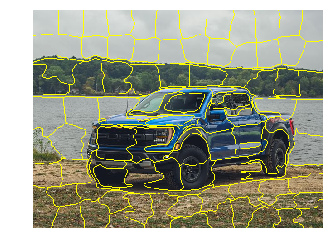

In [16]:
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import cv2

# load the image and apply SLIC and extract (approximately)
# the supplied number of segments
image = cv2.imread("gambar/images.jpg")
segments = slic(img_as_float(image), n_segments = 100, sigma = 5)
# n_segments bermakna jumlah segment yang kita inginkan (dalam hal ini superpixel)
# sigma bermakna ukuran Gaussian kernel yang akan digunakan pada proses segmentasi

# show the output of SLIC
fig = plt.figure("Superpixels")
ax = fig.add_subplot(1, 1, 1)
ax.imshow(mark_boundaries(img_as_float(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), segments))
plt.axis("off")
plt.show()

# loop over the unique segment values
for (i, segVal) in enumerate(np.unique(segments)):
    # construct a mask for the segment
    #print "[x] inspecting segment %d" % (i)
    mask = np.zeros(image.shape[:2], dtype = "uint8")
    mask[segments == segVal] = 255
    # show the masked region
    cv2.imshow("Mask", mask)
    cv2.imshow("Applied", cv2.bitwise_and(image, image, mask = mask))
    cv2.waitKey(0)
    
cv2.destroyAllWindows()

### Apakah itu segmentasi citra?

Segmentasi citra (*image segmentation*) merupakan proses pemisahan citra menjadi komponen-komponen penyusunnya. Segmentasi merupakan langkah penting dalam banyak aplikasi visi komputer. Ada banyak cara untuk melakukan segmentasi citra. Kita dapat melakukan segmentasi citra menggunakan metrik seperti warna, tekstur, lokasi dan lainnya. Semua piksel di dalam satu kawasan memiliki sesuatu yang sama bergantung pada metrik yang kita gunakan.

Di sini kita akan melihat teknik yang dinamakan **GrabCut**. Ini merupakan metode segmentasi berdasarkan metode **graph-cut**. Pada metode grab-cut, kita menganggap keseluruhan citra sebagai graf, lalu kita lakukan segmentasi graf berdasarkan kekuatan tepi pada graf tersebut. Kita membangun graf dengan mempertimbangkan setiap piksel menjadi node dan tepi dibangun di antara node, di mana berat tepi adalah fungsi nilai piksel dari dua node tersebut. Ketika ada tepi, nilai piksel menjadi lebih tinggi, sehingga berat tepi juga lebih tinggi. Graf ini lalu disegmentasi dengan meminimalkan energi Gibss pada graf. Atau disebut juga *maximum entropy segmentation*. Artikel aslinya dapat dibaca di http://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf.

Algoritma GrabCut algorithm:
- Terima citra input dengan kondisi (1) ada *bounding box* yang menspesifikkan lokasi objek pada citra yang ingin disegmentasi atau (2) ada *mask* yang memperkirakan segmentasi
- Secara berulang lakukan langkah berikut:
  1. Langkah 1: memperkirakan distribusi warna dari foreground dan background dengan Gaussian Mixture Model (GMM)
  2. Langkah 2: Membangun *Markov random field* terhadap label piksel (seperti foreground vs background). Artikel untuk langkah 1 & 2: http://research.microsoft.com/pubs/67898/eccv04-GMMRF.pdf
  3. Langkah 3: Mengaplikasikan optimisasi graph-cut untuk menghasilkan segmentasi terakhir

Terkesan rumit, namun OpenCV telah menyediakan fungsi `cv2.grabCut` yang dapat mempermudah pekerjaan segmentasi. Yang penting kita tahu cara menggunakan parameter-parameternya dan mengubahnya bila diperlukan.

In [17]:
# Segmentasi dengan metode GrabCut
import cv2
import numpy as np

# Draw rectangle based on the input selection
def draw_rectangle(event, x, y, flags, params):
    global x_init, y_init, drawing, top_left_pt, bottom_right_pt, img_orig
    
    # Detecting mouse button down event
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x_init, y_init = x, y
    
    # Detecting mouse movement
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            top_left_pt, bottom_right_pt = (x_init,y_init), (x,y)
            img[y_init:y, x_init:x] = 255 - img_orig[y_init:y, x_init:x]
            cv2.rectangle(img, top_left_pt, bottom_right_pt, (0,255,0), 2)
    
    # Detecting mouse button up event
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        top_left_pt, bottom_right_pt = (x_init,y_init), (x,y)
        img[y_init:y, x_init:x] = 255 - img[y_init:y, x_init:x]
        cv2.rectangle(img, top_left_pt, bottom_right_pt, (0,255,0), 2)
        rect_final = (x_init, y_init, x-x_init, y-y_init)
        
        # Run Grabcut on the region of interest
        run_grabcut(img_orig, rect_final)
        
# Grabcut algorithm
def run_grabcut(img_orig, rect_final):
    # Initialize the mask
    mask = np.zeros(img_orig.shape[:2],np.uint8)
    
    # Extract the rectangle and set the region of
    # interest in the above mask
    x,y,w,h = rect_final
    mask[y:y+h, x:x+w] = 1
    
    # Initialize background and foreground models
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    
    # Run Grabcut algorithm
    cv2.grabCut(img_orig, mask, rect_final, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    # Extract new mask
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    
    # Apply the above mask to the image
    img_orig = img_orig*mask2[:,:,np.newaxis]
    
    # Display the image
    cv2.imshow('Output', img_orig)
    
if __name__=='__main__':
    drawing = False
    top_left_pt, bottom_right_pt = (-1,-1), (-1,-1)
    
    # Read the input image: https://i.im.ge/2022/09/24/15nPOD.flower.jpg
    img_orig = cv2.imread("gambar/flower.jpg")
    img = img_orig.copy()
    
    cv2.namedWindow('Input')
    cv2.setMouseCallback('Input', draw_rectangle)
    
    while True:
        cv2.imshow('Input', img)
        # The control breaks once q key is pressed
        if cv2.waitKey(1) & 0xff == ord('q'):
            break
    cv2.destroyAllWindows()

Dengan adanya perkembangan deep learning, terdapat metode segmentasi menggunakan deep learning yaitu *Faster R-CNN and U-Net*. Apakah ini bermakna GrabCut tidak relevan lagi untuk digunakan? 

Sama sekali tidak. *Faster R-CNN and U-Net* memang dapat secara otomatis menghasilkan mask yang dapat mensegmentasi objek (foreground) dari background, namun hasilnya tidak rapi. Sehingga kita perlu menggunakan GrabCut untuk menghasilkan segmentasi objek yang lebih bagus dan rapi.

In [18]:
# Latihan 1
# Ambil gambar dengan menggunakan kamera HP anda lalu upload ke situs https://im.ge/
# akses gambar tersebut langsung dengan menggunakan direct link yang diberikan
# lalu gunakan program seam carving untuk mengubah ukuran lebar dari gambar tersebut

import cv2
import wget
# Mau download silahkan uncomment
# download image from https://i.im.ge/2022/10/14/2701Ry.WhatsApp-Image-2022-10-14-at-4-37-03-PM.jpg and save it as image.jpg
# url = 'https://i.im.ge/2022/10/14/2701Ry.WhatsApp-Image-2022-10-14-at-4-37-03-PM.jpg'
# wget.download(url, 'image_latihan1Prak6.jpg')

# load image
img = cv2.imread('WhatsApp Image 2022-10-14 at 4.37.03 PM.jpeg')
cv2.imshow('Original Image', img)

# resize image
img_scale = cv2.resize(img,(500,500), interpolation = cv2.INTER_AREA)
cv2.imshow('Resized Image', img_scale)
cv2.waitKey()
cv2.destroyAllWindows()



### Watershed algorithm

Algoritma watershed merupakan algoritma klasik untuk segmentasi dan sangat berguna untuk mengekstraksi objek yang saling bersentuhan atau overlap pada suatu citra, seperti pada gambar koin di bawah ini.

[![koin1](https://i.im.ge/2022/10/02/1R47k9.koin1.md.png)](https://im.ge/i/1R47k9)

Apabila kita menggunakan metode tradisional seperti thresholding dan deteksi kontur, kita tidak dapat mengekstrak koin tersebut secara individu, namun apabila kita mengaplikasikan algoritma watershed maka kita dapat mendeteksi dan mengekstrak setiap koin tanpa masalah.

Untuk menggunakan algoritma watershed, kita memulai dengan membuat *user-defined marker*. Marker ini bisa didapat melalui point-dan-click atau secara otomatis menggunakan thresholding atau operasi morfologi. Berdasarkan marker tersebut, algoritma watershed memperlakukan piksel pada input citra sebagai *local elevation* atau *topography*. Metode ini "membanjiri" lembah dimulai dari marker dan bergerak ke luar hingga saling bertemu dengan lembah dari marker lainnya. Untuk mendapatkan segmentasi watershed yang akurat, maka posisi marker haruslah tepat.

Pertama kita akan melihat contoh berikut ini yang belum menggunakan algoritma watershed.

In [19]:
# Latihan 2
# Gunakan gambar yang sama pada latihan di atas, lalu ubah program segmentasi 
# yang disediakan pada modul ini



# Segmentasi dengan metode GrabCut
import cv2
import numpy as np

# Draw rectangle based on the input selection
def draw_rectangle(event, x, y, flags, params):
    global x_init, y_init, drawing, top_left_pt, bottom_right_pt, img_orig
    
    # Detecting mouse button down event
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x_init, y_init = x, y
    
    # Detecting mouse movement
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            top_left_pt, bottom_right_pt = (x_init,y_init), (x,y)
            img[y_init:y, x_init:x] = 255 - img_orig[y_init:y, x_init:x]
            cv2.rectangle(img, top_left_pt, bottom_right_pt, (0,255,0), 2)
    
    # Detecting mouse button up event
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        top_left_pt, bottom_right_pt = (x_init,y_init), (x,y)
        img[y_init:y, x_init:x] = 255 - img[y_init:y, x_init:x]
        cv2.rectangle(img, top_left_pt, bottom_right_pt, (0,255,0), 2)
        rect_final = (x_init, y_init, x-x_init, y-y_init)
        
        # Run Grabcut on the region of interest
        run_grabcut(img_orig, rect_final)
        
# Grabcut algorithm
def run_grabcut(img_orig, rect_final):
    # Initialize the mask
    mask = np.zeros(img_orig.shape[:2],np.uint8)
    
    # Extract the rectangle and set the region of
    # interest in the above mask
    x,y,w,h = rect_final
    mask[y:y+h, x:x+w] = 1
    
    # Initialize background and foreground models
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    
    # Run Grabcut algorithm
    cv2.grabCut(img_orig, mask, rect_final, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    
    # Extract new mask
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    
    # Apply the above mask to the image
    img_orig = img_orig*mask2[:,:,np.newaxis]
    
    # Display the image
    cv2.imshow('Output', img_orig)
    
if __name__=='__main__':
    drawing = False
    top_left_pt, bottom_right_pt = (-1,-1), (-1,-1)
    
    img_orig = cv2.imread("WhatsApp Image 2022-10-14 at 4.37.03 PM.jpeg")
    img = img_orig.copy()
    
    cv2.namedWindow('Input')
    cv2.setMouseCallback('Input', draw_rectangle)
    
    while True:
        cv2.imshow('Input', img)
        # The control breaks once q key is pressed
        if cv2.waitKey(1) & 0xff == ord('q'):
            break
    cv2.destroyAllWindows()

In [20]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import imutils
import cv2

# load the image and perform pyramid mean shift filtering to aid the thresholding step
# Download gambar https://i.im.ge/2022/10/02/1R4bsT.koin2.png
image = cv2.imread("gambar/koin2.png")
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
cv2.imshow("Input", image)

# convert the mean shift image to grayscale, then apply Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2.imshow("Thresh", thresh)

# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))

# loop over the contours
for (i, c) in enumerate(cnts):
    # draw the contour
    ((x, y), _) = cv2.minEnclosingCircle(c)
    cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
# show the output image
cv2.imshow("Image", image)

cv2.waitKey(0)
cv2.destroyAllWindows()

[INFO] 1 unique contours found


Percobaan di atas hanya menggunakan thresholding sederhana dan deteksi kontur namun ternyata hanya menemukan 1 kontur saja (1 koin), padahal sebenarnya ada 9 koin pada citra tersebut. Masalah ini muncul karena batas dari koin saling bersentuhan pada citra tersebut sehingga fungsi `cv2.findContours` hanya dapat melihat grup koin sebagai satu objek single walau sebenarnya ada banyak koin.

Percobaan berikut ini akan menggunakan algoritma watershed.

In [21]:
# import the necessary packages
from skimage.feature import peak_local_max
#from skimage.morphology import watershed

from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import imutils
import cv2

# load the image and perform pyramid mean shift filtering to aid the thresholding step
# Download gambar https://i.im.ge/2022/10/02/1R4bsT.koin2.png
image = cv2.imread("gambar/koin3.png")
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
cv2.imshow("Input", image)

# convert the mean shift image to grayscale, then apply Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2.imshow("Thresh", thresh)

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this distance map
D = ndimage.distance_transform_edt(thresh)
#localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)
localMax = peak_local_max(D, indices=False, min_distance=20, labels=thresh)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
cv2.imshow("Output", image)

cv2.waitKey(0)
cv2.destroyAllWindows()

/home/abdulhafidh/anaconda3/lib/python3.7/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


[INFO] 9 unique segments found


In [22]:
# Latihan 3
# Gunakan gambar https://i.im.ge/2022/10/02/1RBbcM.koin3.png yang memiliki overlap koin
# lalu ubah program segmentasi algoritma watershed 
# yang disediakan pada modul ini
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import imutils
import cv2

# load the image and perform pyramid mean shift filtering to aid the thresholding step
image = cv2.imread("gambar/koin4.png")
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
cv2.imshow("Input", image)

# convert the mean shift image to grayscale, then apply Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2.imshow("Thresh", thresh)

# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))

# loop over the contours
for (i, c) in enumerate(cnts):
    # draw the contour
    ((x, y), _) = cv2.minEnclosingCircle(c)
    cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
# show the output image
cv2.imshow("Image", image)

cv2.waitKey(0)
cv2.destroyAllWindows()

[INFO] 3 unique contours found
